<ipython-input-55-ebe49c5a8336>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df[label_column]


351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

=== Logistic Regression ===
Accuracy : 0.9880
Precision: 0.9919
Recall   : 0.9850
F1-Score : 0.9885
AUC      : 0.9985

=== CNN (Deep Learning) ===
Accuracy : 0.9766
Precision: 0.9682
Recall   : 0.9876
F1-Score : 0.9778
AUC      : 0.9976

=== Final Comparison ===
Logistic Regression Accuracy : 0.9880
CNN Accuracy                 : 0.9766
Logistic Regression performed better.


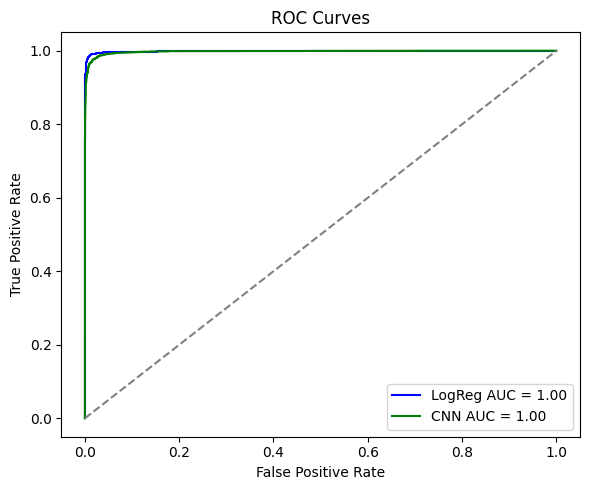

In [55]:
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# --- Setup ---
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# --- Preprocessing ---
def preprocess_dataframe(df):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def clean_text(text):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = re.sub(f"[{string.punctuation}]", "", text)
        text = re.sub(r'\d+', '', text)
        words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
        return ' '.join(words)

    df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
    df['cleaned_content'] = df['content'].apply(clean_text)
    df = df[df['cleaned_content'].str.split().str.len() > 5]

    label_cols = ['label', 'is_fake', 'fake', 'target']
    label_column = next((col for col in label_cols if col in df.columns), df.columns[0])
    df['label'] = df[label_column]

    return df

# --- Load Dataset ---
try:
    df = pd.read_csv('fake_real_news.csv')
except FileNotFoundError:
    df = pd.DataFrame({
        'title': [
            "Cure for common cold", "Aliens invade Earth", "City park approved",
            "Bribery scandal uncovered", "Elvis on Mars", "Economic policy released",
            "Fake vaccine news", "Company X profits", "Moon landing hoax", "Charity raises funds"
        ],
        'text': [
            "Scientists have discovered a cure for the common cold.",
            "World leaders panic as aliens invade Earth.",
            "New development plan gets approval for central city park.",
            "High-ranking official resigns after bribery exposed.",
            "Shocking photos claim Elvis Presley is alive on Mars.",
            "New policies aim to reduce unemployment and inflation.",
            "Media accused of fabricating vaccine side effects.",
            "Tech company reports highest profits in a decade.",
            "Footage reveals the moon landing was a staged hoax.",
            "Local charity collects donations for homeless support."
        ],
        'label': [1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
    })

df = preprocess_dataframe(df)

# --- Split ---
X = df['cleaned_content']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# === Logistic Regression + HashingVectorizer ===
vectorizer = HashingVectorizer(n_features=2**12, alternate_sign=False)
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

lr_model = LogisticRegression(max_iter=1000, solver='liblinear')
lr_model.fit(X_train_vec, y_train)

y_lr_pred = lr_model.predict(X_test_vec)
y_lr_prob = lr_model.predict_proba(X_test_vec)[:, 1]

# === CNN Model ===
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

cnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=64),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
cnn_model.fit(X_train_pad, y_train, epochs=1, batch_size=16, validation_split=0.2, verbose=0)

y_cnn_prob = cnn_model.predict(X_test_pad).flatten()
y_cnn_pred = (y_cnn_prob > 0.5).astype(int)

# === Results Summary ===
def print_metrics(name, y_true, y_pred, y_prob):
    print(f"\n=== {name} ===")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score : {f1_score(y_true, y_pred):.4f}")
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    print(f"AUC      : {auc(fpr, tpr):.4f}")
    return accuracy_score(y_true, y_pred)

acc_lr = print_metrics("Logistic Regression", y_test, y_lr_pred, y_lr_prob)
acc_cnn = print_metrics("CNN (Deep Learning)", y_test, y_cnn_pred, y_cnn_prob)

# === Final Model Comparison ===
print("\n=== Final Comparison ===")
print(f"Logistic Regression Accuracy : {acc_lr:.4f}")
print(f"CNN Accuracy                 : {acc_cnn:.4f}")
if acc_cnn > acc_lr:
    print("CNN performed better.")
elif acc_cnn < acc_lr:
    print("Logistic Regression performed better.")
else:
    print("Both models performed equally well.")

# Optional: plot ROC curves side-by-side
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_lr_prob)
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_cnn_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg AUC = {auc(fpr_lr, tpr_lr):.2f}', color='blue')
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN AUC = {auc(fpr_cnn, tpr_cnn):.2f}', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()
